# Homework Problem 0: Making sure you're set up with python
### You will need to be able to run all of these cells without error

In [1]:
import numpy as np
import pandas as pd 
%matplotlib inline

In [2]:
import tqdm


for i in tqdm.tqdm(range(3)):
    print("look at the pretty progress bar")


100%|██████████| 3/3 [00:00<00:00, 38956.38it/s]

look at the pretty progress bar
look at the pretty progress bar
look at the pretty progress bar


In [3]:
# make sure numpy works
arr = np.arange(30).reshape(10, 3)
arr.sum(axis=0)

array([135, 145, 155])

<Axes: >

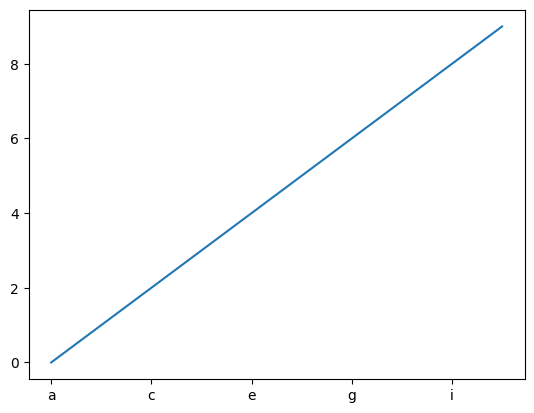

In [4]:
# make sure pandas works
pd.Series(range(10), index=list("abcdefghij")).plot()

In [5]:
# make sure scikit learn works
from sklearn.preprocessing import normalize

arr = np.arange(30).reshape(10, 3)
new_arr = normalize(arr)
(new_arr * new_arr).sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
from tensorflow.keras.utils import to_categorical

arr = np.array([[1, 2, 1, 0, 5], [3, 4, 1, 0, 5]])
assert to_categorical(arr).shape == (2, 5, 6)

In [7]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow as tf

K.clear_session()
inpt = Input(shape=(10,))
mat = Dense(1, input_shape=(10,))

res = mat(K.variable(np.ones((10, 1))))

if tf.__version__.startswith("1"):
    print(
        f"you have tensorflow version {tf.__version__}."
        "Your code may not be compatible with everything we do in class"
    )
    result = K.eval(res)
else:
    result = res.numpy()
    assert (result == K.eval(res)).all()

print(result)

[[-1.003889]
 [-1.003889]
 [-1.003889]
 [-1.003889]
 [-1.003889]
 [-1.003889]
 [-1.003889]
 [-1.003889]
 [-1.003889]
 [-1.003889]]


/Users/bluebird/.pyenv/versions/3.10.11/envs/venv310/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
K.clear_session()
inpt = Input(shape=(10,))
mat = Dense(1, input_shape=(10,))
outpt = mat(inpt)

model = Model(inpt, outpt)
model.compile("adam", loss="binary_crossentropy")
assert model.count_params() == 11
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11 (44.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 0 (0.00 B)

# Homework Problem 1: Company Descriptions from Wikipedia
Downloading data from the web is a large part of working with text.
Importantly, it can be difficult to find the __right__ data. 
Here, we will download the company descriptions from wikipedia for the current set of S&P500 companies. 

## The `wikipedia` package
You can install it with `pip install wikipedia`

We will use `wikipeda.page` to grab data
```python
import wikipedia

page = wikipedia.page(page_url)
print(page.content)
```

In [9]:
import numpy as np
import pandas as pd
%matplotlib inline

from tqdm import tqdm
import wikipedia

## Part 0: get the list of the S&P500 companies
### Hint, a `wikipedia` page has a method `html()` which returns the html from the page
### pandas has `read_html` https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.read_html.html

In [2]:
import requests
from bs4 import BeautifulSoup
import json

# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')

# Find the table with class 'wikitable sortable'
table = soup.find('table', {'class': 'wikitable sortable'})

# Initialize a list to store company data
companies = []

# Iterate through table rows, skipping the header
for row in table.find_all('tr')[1:]:
    cols = row.find_all('td')
    if len(cols) >= 8:  # Ensure we have the right table
        
        # Find instances of links in the first two columns
        symbol_link = cols[0].find('a')
        name_link = cols[1].find('a')
        
        company = {
            "symbol": cols[0].text.strip(),
            "name": cols[1].text.strip(),
            "gics_sector": cols[2].text.strip(),
            "gics_sub_sector": cols[3].text.strip(),
            "headquarters": cols[4].text.strip(),
            "date_added": cols[5].text.strip(),
            "cik": cols[6].text.strip(),
            "founded": cols[7].text.strip(),
            "wikipedia_page": f"https://en.wikipedia.org{name_link['href']}" if name_link else None,
            "nyse_page": f"{symbol_link['href']}" if symbol_link else None
        }
        companies.append(company)

# print(companies[0])
print(len(companies))

503


## Part 2: For every S&P500 company, get the page content

In [11]:
import time

# Scrape all pages
for company in tqdm(companies):
    try:
        url = company['wikipedia_page'].split("/")[-1]
        page = wikipedia.page(url, auto_suggest=False)
        company['page_content'] = page.content
        time.sleep(1)
    except Exception as e:
        print(f"Problem using {company['wikipedia_page']}, using search term instead.")
        try:
            page = wikipedia.page(company['name'], auto_suggest=False)
            company['page_content'] = page.content
            time.sleep(1)
        except wikipedia.exceptions.PageError:
            print(f"Page not found for {company['name']}, returning None.")

  9%|▉         | 45/503 [01:08<11:42,  1.53s/it]

Problem using https://en.wikipedia.org/wiki/Arthur_J._Gallagher_%26_Co., using search term instead.


  9%|▉         | 47/503 [01:11<11:45,  1.55s/it]

Problem using https://en.wikipedia.org/wiki/AT%26T, using search term instead.


 12%|█▏        | 59/503 [01:29<11:57,  1.62s/it]

Problem using https://en.wikipedia.org/wiki/Bath_%26_Body_Works,_Inc., using search term instead.


 15%|█▌        | 76/503 [01:56<10:55,  1.53s/it]

Problem using https://en.wikipedia.org/wiki/Brown_%26_Brown, using search term instead.


 15%|█▌        | 77/503 [01:58<11:16,  1.59s/it]

Problem using https://en.wikipedia.org/wiki/Brown%E2%80%93Forman, using search term instead.


 18%|█▊        | 89/503 [02:16<10:41,  1.55s/it]

Problem using https://en.wikipedia.org/wiki/Carnival_Corporation_%26_plc, using search term instead.


 21%|██▏       | 107/503 [02:44<10:12,  1.55s/it]

Problem using https://en.wikipedia.org/wiki/Church_%26_Dwight, using search term instead.


 29%|██▊       | 144/503 [03:39<08:45,  1.46s/it]

Problem using https://en.wikipedia.org/wiki/Deere_%26_Company, using search term instead.


 31%|███       | 154/503 [03:55<09:08,  1.57s/it]

Problem using https://en.wikipedia.org/wiki/Domino%27s, using search term instead.


 36%|███▌      | 180/503 [04:35<06:12,  1.15s/it]

Problem using https://en.wikipedia.org/wiki/The_Est%C3%A9e_Lauder_Companies, using search term instead.
Page not found for Estée Lauder Companies (The), returning None.


 47%|████▋     | 238/503 [06:04<06:33,  1.49s/it]

Problem using https://en.wikipedia.org/wiki/Host_Hotels_%26_Resorts, using search term instead.


 50%|████▉     | 251/503 [06:24<06:22,  1.52s/it]

Problem using https://en.wikipedia.org/w/index.php?title=Insulet_Corporation&action=edit&redlink=1, using search term instead.


 50%|█████     | 252/503 [06:24<05:00,  1.20s/it]

Page not found for Insulet Corporation, returning None.


 50%|█████     | 254/503 [06:27<05:30,  1.33s/it]

Problem using https://en.wikipedia.org/wiki/International_Flavors_%26_Fragrances, using search term instead.


 53%|█████▎    | 265/503 [06:44<06:23,  1.61s/it]

Problem using https://en.wikipedia.org/wiki/Jack_Henry_%26_Associates, using search term instead.


 53%|█████▎    | 267/503 [06:47<06:13,  1.58s/it]

Problem using https://en.wikipedia.org/wiki/Johnson_%26_Johnson, using search term instead.


 59%|█████▉    | 296/503 [07:32<05:19,  1.54s/it]

Problem using https://en.wikipedia.org/wiki/Lowe%27s, using search term instead.


 59%|█████▉    | 299/503 [07:37<05:07,  1.51s/it]

Problem using https://en.wikipedia.org/wiki/M%26T_Bank, using search term instead.


 61%|██████▏   | 309/503 [07:52<05:08,  1.59s/it]

Problem using https://en.wikipedia.org/wiki/McCormick_%26_Company, using search term instead.


 62%|██████▏   | 310/503 [07:54<05:11,  1.61s/it]

Problem using https://en.wikipedia.org/wiki/McDonald%27s, using search term instead.


 62%|██████▏   | 313/503 [07:58<04:54,  1.55s/it]

Problem using https://en.wikipedia.org/wiki/Merck_%26_Co., using search term instead.


 65%|██████▌   | 329/503 [08:23<04:28,  1.54s/it]

Problem using https://en.wikipedia.org/wiki/Moody%27s_Corporation, using search term instead.


 70%|███████   | 353/503 [08:59<03:39,  1.46s/it]

Problem using https://en.wikipedia.org/wiki/O%27Reilly_Auto_Parts, using search term instead.


 74%|███████▍  | 372/503 [09:28<03:20,  1.53s/it]

Problem using https://en.wikipedia.org/wiki/PG%26E, using search term instead.


 76%|███████▌  | 381/503 [09:42<03:03,  1.51s/it]

Problem using https://en.wikipedia.org/wiki/Procter_%26_Gamble, using search term instead.


 81%|████████  | 408/503 [10:24<02:24,  1.52s/it]

Problem using https://en.wikipedia.org/wiki/S%26P_Global, using search term instead.


 84%|████████▍ | 424/503 [10:48<01:57,  1.48s/it]

Problem using https://en.wikipedia.org/wiki/Stanley_Black_%26_Decker, using search term instead.


100%|██████████| 503/503 [12:48<00:00,  1.53s/it]


### Testing

In [12]:
#Check for companies that had an error and store into a new list
error_companies = [company for company in companies if 'page_content' not in company]
print(error_companies)
print(len(error_companies))

[{'symbol': 'EL', 'name': 'Estée Lauder Companies (The)', 'gics_sector': 'Consumer Staples', 'gics_sub_sector': 'Personal Care Products', 'headquarters': 'New York City, New York', 'date_added': '2006-01-05', 'cik': '0001001250', 'founded': '1946', 'wikipedia_page': 'https://en.wikipedia.org/wiki/The_Est%C3%A9e_Lauder_Companies', 'nyse_page': 'https://www.nyse.com/quote/XNYS:EL'}, {'symbol': 'PODD', 'name': 'Insulet Corporation', 'gics_sector': 'Health Care', 'gics_sub_sector': 'Health Care Equipment', 'headquarters': 'Acton, Massachusetts', 'date_added': '2023-03-15', 'cik': '0001145197', 'founded': '2000', 'wikipedia_page': 'https://en.wikipedia.org/w/index.php?title=Insulet_Corporation&action=edit&redlink=1', 'nyse_page': 'https://www.nasdaq.com/market-activity/stocks/podd'}]
2


In [13]:
# Fix the error companies manually
for company in companies: 
    if company['symbol'] == 'EL':
        url = "The_Estée_Lauder_Companies"
        page = wikipedia.page(url, auto_suggest=False)
        company['page_content'] = page.content
    if company['symbol'] == 'PODD':
        company['page_content'] = "No page found"


In [14]:
#Re-check for companies that had an error and store into a new list
error_companies = [company for company in companies if 'page_content' not in company]
print(error_companies)
print(len(error_companies))

[]
0


In [15]:
# Check first 100 characters of the page content for each company and export to a csv file
df = pd.DataFrame(companies)
df['page_content'] = df['page_content'].str[:100]
df.to_csv("companies.csv", index=False)


### Export

In [3]:
# Convert to list JSON and export to file to save
json_data = json.dumps(companies, indent=2)
# print(json_data)

# Save to a file
with open('sp500_companies.json', 'w') as f:
    f.write(json_data)

## Part 3: Content length
 - For every page, compute the length of the text (how many characters)
 - What is the mean length(number of characters) for each gics sector. 

In [17]:
import json
import pandas as pd

# Import json file and convert to DataFrame
with open('sp500_companies.json', 'r') as f:
    companies = json.load(f)

df = pd.DataFrame(companies)
df.head()

,symbol,name,gics_sector,gics_sub_sector,headquarters,date_added,cik,founded,wikipedia_page,nyse_page,page_content
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902,https://en.wikipedia.org/wiki/3M,https://www.nyse.com/quote/XNYS:MMM,3M Company (originally the Minnesota Mining an...
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916,https://en.wikipedia.org/wiki/A._O._Smith,https://www.nyse.com/quote/XNYS:AOS,A. O. Smith Corporation is an American manufac...
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888,https://en.wikipedia.org/wiki/Abbott_Laboratories,https://www.nyse.com/quote/XNYS:ABT,Abbott Laboratories is an American multination...
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888),https://en.wikipedia.org/wiki/AbbVie,https://www.nyse.com/quote/XNYS:ABBV,AbbVie Inc. is an American pharmaceutical comp...
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989,https://en.wikipedia.org/wiki/Accenture,https://www.nyse.com/quote/XNYS:ACN,Accenture plc is an Irish-American professiona...


In [18]:
# Add a column with the length of the page content to the DataFrame
df['page_length'] = df['page_content'].apply(len)
df.head()


,symbol,name,gics_sector,gics_sub_sector,headquarters,date_added,cik,founded,wikipedia_page,nyse_page,page_content,page_length
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902,https://en.wikipedia.org/wiki/3M,https://www.nyse.com/quote/XNYS:MMM,3M Company (originally the Minnesota Mining an...,20635
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916,https://en.wikipedia.org/wiki/A._O._Smith,https://www.nyse.com/quote/XNYS:AOS,A. O. Smith Corporation is an American manufac...,9148
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888,https://en.wikipedia.org/wiki/Abbott_Laboratories,https://www.nyse.com/quote/XNYS:ABT,Abbott Laboratories is an American multination...,20957
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888),https://en.wikipedia.org/wiki/AbbVie,https://www.nyse.com/quote/XNYS:ABBV,AbbVie Inc. is an American pharmaceutical comp...,11840
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989,https://en.wikipedia.org/wiki/Accenture,https://www.nyse.com/quote/XNYS:ACN,Accenture plc is an Irish-American professiona...,7304


In [19]:
# Calculate average page length for each sector
sector_avg = df.groupby('gics_sector')['page_length'].mean()

# Print and sort by average page length
print(sector_avg.sort_values(ascending=False))

gics_sector
Communication Services    26549.409091
Consumer Discretionary    20932.634615
Consumer Staples          20309.315789
Information Technology    17908.656716
Financials                17204.169014
Utilities                 13136.096774
Health Care               12409.634921
Energy                    12357.590909
Industrials               11659.307692
Materials                 10269.535714
Real Estate                4292.000000
Name: page_length, dtype: float64


## Part 4: Count how many times `computer` appears in the content for each company
 - What is the mean number of times it occurs in each sector?
 - Do these results make sense

In [20]:
# Count how many times the word 'computer' appears in each page content
df['computer_count'] = df['page_content'].str.count('computer')
df.head()

,symbol,name,gics_sector,gics_sub_sector,headquarters,date_added,cik,founded,wikipedia_page,nyse_page,page_content,page_length,computer_count
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,0000066740,1902,https://en.wikipedia.org/wiki/3M,https://www.nyse.com/quote/XNYS:MMM,3M Company (originally the Minnesota Mining an...,20635,0
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,0000091142,1916,https://en.wikipedia.org/wiki/A._O._Smith,https://www.nyse.com/quote/XNYS:AOS,A. O. Smith Corporation is an American manufac...,9148,0
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,0000001800,1888,https://en.wikipedia.org/wiki/Abbott_Laboratories,https://www.nyse.com/quote/XNYS:ABT,Abbott Laboratories is an American multination...,20957,0
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,0001551152,2013 (1888),https://en.wikipedia.org/wiki/AbbVie,https://www.nyse.com/quote/XNYS:ABBV,AbbVie Inc. is an American pharmaceutical comp...,11840,0
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,0001467373,1989,https://en.wikipedia.org/wiki/Accenture,https://www.nyse.com/quote/XNYS:ACN,Accenture plc is an Irish-American professiona...,7304,3


In [21]:
# What is the average number of times 'computer' appears in each sector?
sector_computer_avg = df.groupby('gics_sector')['computer_count'].mean()

# Print and sort by average computer count
print(sector_computer_avg.sort_values(ascending=False))

# Yes, these results make sense. The technology sector has the highest average count of the word 'computer'.

gics_sector
Information Technology    4.238806
Communication Services    0.772727
Consumer Discretionary    0.634615
Industrials               0.487179
Financials                0.239437
Energy                    0.227273
Health Care               0.079365
Consumer Staples          0.078947
Utilities                 0.032258
Materials                 0.000000
Real Estate               0.000000
Name: computer_count, dtype: float64


## Part 5: repeat part 4 with lots of words
 - Try `['computer', 'oil', 'debt', 'drug', 'building', 'food']`
 - Add your own words

In [22]:
original_words = ['computer', 'oil', 'debt', 'drug', 'building', 'food']
new_words = ['finance', 'crypto', 'technology','construction','supercalifragilisticexpialidocious']
words = original_words + new_words
words.sort()
print(words)

['building', 'computer', 'construction', 'crypto', 'debt', 'drug', 'finance', 'food', 'oil', 'supercalifragilisticexpialidocious', 'technology']


In [23]:
# one way to do this is to make a dataframe of counts,
# initialize all to 0, and then loop through and count the occurences
counts = pd.DataFrame(0, index=df.symbol.tolist(), columns=words)

# Append the gics sector to the counts DataFrame
counts['gics_sector'] = df.set_index('symbol')['gics_sector']
counts.head()

,building,computer,construction,crypto,debt,drug,finance,food,oil,supercalifragilisticexpialidocious,technology,gics_sector
MMM,0,0,0,0,0,0,0,0,0,0,0,Industrials
AOS,0,0,0,0,0,0,0,0,0,0,0,Industrials
ABT,0,0,0,0,0,0,0,0,0,0,0,Health Care
ABBV,0,0,0,0,0,0,0,0,0,0,0,Health Care
ACN,0,0,0,0,0,0,0,0,0,0,0,Information Technology


In [24]:
# Loop through the DataFrame of content and count the occurences of each word
for i, row in df.iterrows():
    for word in words:
        counts.loc[row['symbol'], word] = row['page_content'].count(word)
counts.head()

,building,computer,construction,crypto,debt,drug,finance,food,oil,supercalifragilisticexpialidocious,technology,gics_sector
MMM,4,0,0,0,1,1,0,3,2,0,5,Industrials
AOS,0,0,0,0,0,0,0,0,8,0,0,Industrials
ABT,0,0,0,0,0,12,0,0,0,0,1,Health Care
ABBV,1,0,0,0,0,16,0,0,0,0,3,Health Care
ACN,0,3,0,0,0,0,0,0,0,0,4,Information Technology


In [25]:
# Show the average count of each word by sector
counts.groupby('gics_sector').mean()

,building,computer,construction,crypto,debt,drug,finance,food,oil,supercalifragilisticexpialidocious,technology
gics_sector,,,,,,,,,,,
Communication Services,1.636364,0.772727,0.454545,0.136364,0.954545,0.136364,0.363636,0.090909,0.045455,0.0,2.045455
Consumer Discretionary,1.269231,0.634615,0.807692,0.115385,0.538462,0.211538,0.192308,2.634615,0.538462,0.0,1.615385
Consumer Staples,0.868421,0.078947,0.263158,0.000000,0.184211,0.657895,0.052632,7.815789,2.157895,0.0,0.421053
Energy,1.045455,0.227273,0.954545,0.000000,0.454545,0.045455,0.090909,0.136364,14.136364,0.0,0.681818
Financials,1.676056,0.239437,0.239437,0.267606,0.915493,0.098592,0.929577,0.169014,0.535211,0.0,1.070423
Health Care,0.365079,0.079365,0.238095,0.047619,0.269841,5.587302,0.063492,0.253968,0.126984,0.0,1.952381
Industrials,1.564103,0.487179,0.807692,0.000000,0.320513,0.076923,0.128205,0.230769,0.679487,0.0,1.371795
Information Technology,0.895522,4.238806,0.507463,0.208955,0.149254,0.059701,0.238806,0.104478,0.134328,0.0,4.835821
Materials,0.821429,0.000000,0.857143,0.000000,0.107143,0.035714,0.107143,1.178571,1.250000,0.0,1.107143
